# Minimax Linkage 

There is no minimax linkage implemented in ```scipy.cluster.hierarchy``` as of Feb 2021. There is a standalone package [pyprotoclust](https://github.com/andgoldschmidt/pyprotoclust), possibly the only python package available for minimax linkage, but a simple pip install doesn't always work. 

Below is a brute force implementation. 

There is an nearest neighbor chain algorithm which is used in scipy for complete linkage. Minimax linkage can be implemented the same way too. 

The update rule of minimax linkage is

\begin{align*}
d(G_1 \cup G_2, H) = \min_{i\in G_1\cup G_2 \cup H} \max_{j\in G_1\cup G_2 \cup H} d_{ij}
\end{align*}

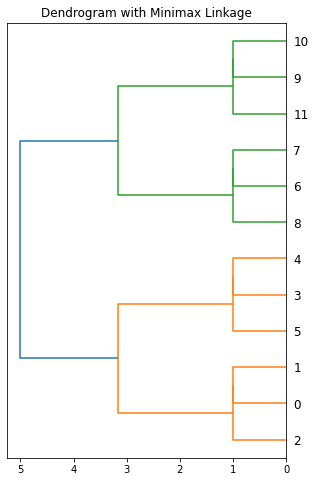

CPU times: user 193 ms, sys: 88.6 ms, total: 282 ms
Wall time: 288 ms


,0,1,2,3
0,0,1,1.000000,2
1,2,12,1.000000,3
2,3,4,1.000000,2
3,5,14,1.000000,3
4,6,7,1.000000,2
5,8,16,1.000000,3
6,9,10,1.000000,2
7,11,18,1.000000,3
8,13,15,3.162278,6
9,17,19,3.162278,6


In [11]:
%%time

import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

def minimax_linkage(dist):
    n = int((np.sqrt(8*len(dist) + 1) + 1)/2)
    
    def d(i, j): return dist[n*i+j-((i+2)*(i+1))//2] if i<j else (0 if i==j else d(j, i))
    def r(i, G): return max(d(i, j) for j in G)
    
    Z = []
    clusters = {i: set([i]) for i in range(n)}
    for i in range(n-1):
        min_d = math.inf
        for (idxG, G), (idxH, H) in combinations(clusters.items(), 2):
            dminimax = min(r(x, G|H) for x in G|H)
            if dminimax < min_d:
                min_d = dminimax
                to_merge = [idxG, idxH, dminimax, len(G|H)]
        Z.append(to_merge)
        idxG, idxH, _, _ = to_merge
        clusters[n+i] = clusters.pop(idxG) | clusters.pop(idxH)
        
    return Z

X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax_linkage(pdist(X))
# Z = hierarchy.complete(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z, ax=ax, orientation='left')
ax.set(title='Dendrogram with Minimax Linkage')
plt.show()

DataFrame(Z)

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist


class LinkageUnionFind:
    """Structure for fast cluster labeling in unsorted dendrogram."""
#     cdef int[:] parent
#     cdef int[:] size
#     cdef int next_label

    def __init__(self, n):
        self.parent = np.arange(2 * n - 1)
        self.next_label = n
        self.size = np.ones(2 * n - 1)

    def merge(self, x, y):
        self.parent[x] = self.next_label
        self.parent[y] = self.next_label
        size = self.size[x] + self.size[y]
        self.size[self.next_label] = size
        self.next_label += 1
        return size

    def find(self, x):
        p = x

        while self.parent[x] != x:
            x = self.parent[x]

        while self.parent[p] != x:
            p, self.parent[p] = self.parent[p], x

        return x


def label(Z, n):
    """Correctly label clusters in unsorted dendrogram."""
    uf = LinkageUnionFind(n)
    for i in range(n - 1):
        x, y = int(Z[i, 0]), int(Z[i, 1])
        x_root, y_root = uf.find(x), uf.find(y)
        if x_root < y_root:
            Z[i, 0], Z[i, 1] = x_root, y_root
        else:
            Z[i, 0], Z[i, 1] = y_root, x_root
        Z[i, 3] = uf.merge(x_root, y_root)
        


def condensed_index(n, i, j):
    """
    Calculate the condensed index of element (i, j) in an n x n condensed
    matrix.
    """
    if i < j:
        return int(round(n * i - (i * (i + 1) / 2) + (j - i - 1)))
    elif i > j:
        return int(round(n * j - (j * (j + 1) / 2) + (i - j - 1)))

    
# def nn_chain(dists, n, method):
def minimax(dists):
    """Perform hierarchy clustering using nearest-neighbor chain algorithm.
    Parameters
    ----------
    dists : ndarray
        A condensed matrix stores the pairwise distances of the observations.
    Returns
    -------
    Z : ndarray, shape (n - 1, 4)
        Computed linkage matrix.
    """
    n = int((np.sqrt(8*len(dists) + 1) + 1)/2)
    
    Z_arr = np.empty((n - 1, 4))
    Z = Z_arr

    D = dists.copy()  # Distances between clusters.
    size = np.ones(n, dtype=np.intc)  # Sizes of clusters.

#     new_dist = linkage_methods[method]

    # Variables to store neighbors chain.
    cluster_chain = np.ndarray(n, dtype=np.intc)
    chain_length = 0

#     cdef int i, j, k, x, y, nx, ny, ni
#     cdef double dist, current_min

    for k in range(n - 1):
        if chain_length == 0:
            chain_length = 1
            for i in range(n):
                if size[i] > 0:
                    cluster_chain[0] = i
                    break

        # Go through chain of neighbors until two mutual neighbors are found.
        while True:
            x = cluster_chain[chain_length - 1]

            # We want to prefer the previous element in the chain as the
            # minimum, to avoid potentially going in cycles.
            if chain_length > 1:
                y = cluster_chain[chain_length - 2]
                current_min = D[condensed_index(n, x, y)]
            else:
                current_min = np.inf   # NPY_INFINITYF

            for i in range(n):
                if size[i] == 0 or x == i:
                    continue
                
                dist = D[condensed_index(n, x, i)]
                if dist < current_min:
                    current_min = dist
                    y = i

            if chain_length > 1 and y == cluster_chain[chain_length - 2]:
                break

            cluster_chain[chain_length] = y
            chain_length += 1

        # Merge clusters x and y and pop them from stack.
        chain_length -= 2

        # This is a convention used in fastcluster.
        if x > y:
            x, y = y, x

        # get the original numbers of points in clusters x and y
        nx = size[x]
        ny = size[y]

        # Record the new node.
        Z[k, 0] = x
        Z[k, 1] = y
        Z[k, 2] = current_min
        Z[k, 3] = nx + ny
        size[x] = 0  # Cluster x will be dropped.
        size[y] = nx + ny  # Cluster y will be replaced with the new cluster

        # Update the distance matrix.
        for i in range(n):
            ni = size[i]
            if ni == 0 or i == y:
                continue
                
            D[condensed_index(n, i, y)] = max(D[condensed_index(n, i, x)], D[condensed_index(n, i, y)])  # complete linkage
            # 要 implement minimax 需要知道 x y 裡各有哪些原本資料點的 index，
            # 原本的 distance matrix 要從 dists 裡拿，因為 D 裡的值會一直被覆蓋過去

    # Sort Z by cluster distances.
    order = np.argsort(Z_arr[:, 2], kind='mergesort')
    Z_arr = Z_arr[order]

    # Find correct cluster labels inplace.
    label(Z_arr, n)

    return Z_arr

X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z, ax=ax, orientation='left')
ax.set(title='Dendrogram with Complete Linkage')
plt.show()

DataFrame(Z)

,0,1,2,3
0,0.0,1.0,1.000000,2.0
1,3.0,4.0,1.000000,2.0
2,6.0,7.0,1.000000,2.0
3,9.0,10.0,1.000000,2.0
4,2.0,12.0,1.414214,3.0
5,5.0,13.0,1.414214,3.0
6,8.0,14.0,1.414214,3.0
7,11.0,15.0,1.414214,3.0
8,16.0,17.0,4.123106,6.0
9,18.0,19.0,4.123106,6.0


In [5]:
from pandas import DataFrame

n = len(X)

DataFrame([[condensed_index(12, i, j) if i<j else '' for j in range(12)] for i in range(12)])

,0,1,2,3,4,5,6,7,8,9,10,11
0,,0,1,2,3,4,5,6,7,8,9,10
1,,,11,12,13,14,15,16,17,18,19,20
2,,,,21,22,23,24,25,26,27,28,29
3,,,,,30,31,32,33,34,35,36,37
4,,,,,,38,39,40,41,42,43,44
5,,,,,,,45,46,47,48,49,50
6,,,,,,,,51,52,53,54,55
7,,,,,,,,,56,57,58,59
8,,,,,,,,,,60,61,62
9,,,,,,,,,,,63,64
